# Module 02: Introduction to Convolutional Neural Networks

**Understanding the Magic of Convolution**

Welcome to the heart of computer vision! In this module, you'll learn why CNNs revolutionized image processing and how they work.

## What You'll Learn
- Why regular neural networks struggle with images
- What is a convolution operation?
- Filters and feature maps explained
- Pooling layers and their purpose
- Complete CNN architecture overview
- Real-world applications

## Prerequisites
- Completed Modules 00-01
- Understanding of basic neural networks

## Time Required
45 minutes

In [1]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from scipy.signal import convolve2d

# Set random seed
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Part 1: Why Regular Neural Networks Struggle with Images

### The Problem

In Module 01, we built a simple neural network that flattened images into vectors. This works, but has major issues:

#### 1. **Loses Spatial Information**
- Flattening destroys the 2D structure of images
- Nearby pixels are no longer "neighbors"
- The network can't understand spatial relationships

#### 2. **Too Many Parameters**
- A small 28×28 image = 784 pixels
- With 128 hidden neurons: 100,480 parameters just for first layer!
- A 224×224 RGB image would need: 224×224×3 = 150,528 inputs
- With 1000 hidden neurons: 150 million parameters for first layer alone!

#### 3. **Not Translation Invariant**
- If a cat appears in the top-left vs bottom-right, it's treated as completely different
- Network must learn to recognize cats in every possible position
- Extremely inefficient!

### The Solution: Convolutional Neural Networks

CNNs solve all these problems by:
1. **Preserving spatial structure** - Keep the 2D arrangement
2. **Local connectivity** - Each neuron only looks at a small region
3. **Parameter sharing** - Use the same filter across the entire image
4. **Translation invariance** - Detect features regardless of position

## Part 2: Understanding Convolution

### What is Convolution?

**Convolution** is a mathematical operation that:
- Takes an image (input)
- Applies a **filter** (also called **kernel**)
- Produces a **feature map** (output)

### Visual Analogy

Think of it like:
- **Image**: A large piece of paper with a picture
- **Filter**: A small magnifying glass
- **Process**: Slide the magnifying glass across the image, looking for specific patterns

### How It Works (Step by Step)

1. **Place** the filter (e.g., 3×3) on the top-left corner of the image
2. **Multiply** each filter value with the corresponding image pixel
3. **Sum** all these products to get a single number
4. **Slide** the filter one position to the right
5. **Repeat** until you've covered the entire image

The result is a **feature map** showing where the pattern was detected!

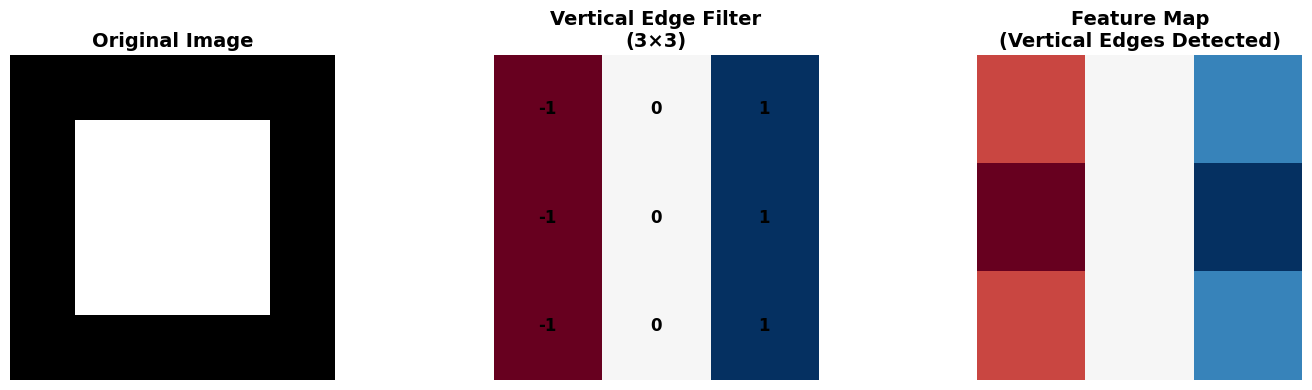

Notice how the filter detected vertical edges!
Original image size: (5, 5)
Filter size: (3, 3)
Feature map size: (3, 3)


In [2]:
# Let's see convolution in action with a simple example

# Create a simple 5×5 image
image = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 1, 1, 1, 0],
    [0, 0, 0, 0, 0]
], dtype=np.float32)

# Create a simple 3×3 filter (detects vertical edges)
filter_vertical = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
], dtype=np.float32)

# Apply convolution
feature_map_vertical = convolve2d(image, filter_vertical, mode='valid')

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original image
axes[0].imshow(image, cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Filter
axes[1].imshow(filter_vertical, cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_title('Vertical Edge Filter\n(3×3)', fontsize=14, fontweight='bold')
axes[1].axis('off')
for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{filter_vertical[i,j]:.0f}',
                    ha='center', va='center', fontsize=12, fontweight='bold')

# Feature map
axes[2].imshow(feature_map_vertical, cmap='RdBu')
axes[2].set_title('Feature Map\n(Vertical Edges Detected)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Notice how the filter detected vertical edges!")
print(f"Original image size: {image.shape}")
print(f"Filter size: {filter_vertical.shape}")
print(f"Feature map size: {feature_map_vertical.shape}")

### Common Filters and What They Detect

Different filters detect different features:

#### 1. **Edge Detection Filters**
- **Vertical edges**: Detect left-to-right changes
- **Horizontal edges**: Detect top-to-bottom changes
- **Diagonal edges**: Detect diagonal patterns

#### 2. **Blur Filters**
- Average nearby pixels
- Smoothen the image

#### 3. **Sharpen Filters**
- Enhance edges and details
- Make images crisper

**In CNNs, the network LEARNS what filters to use!**

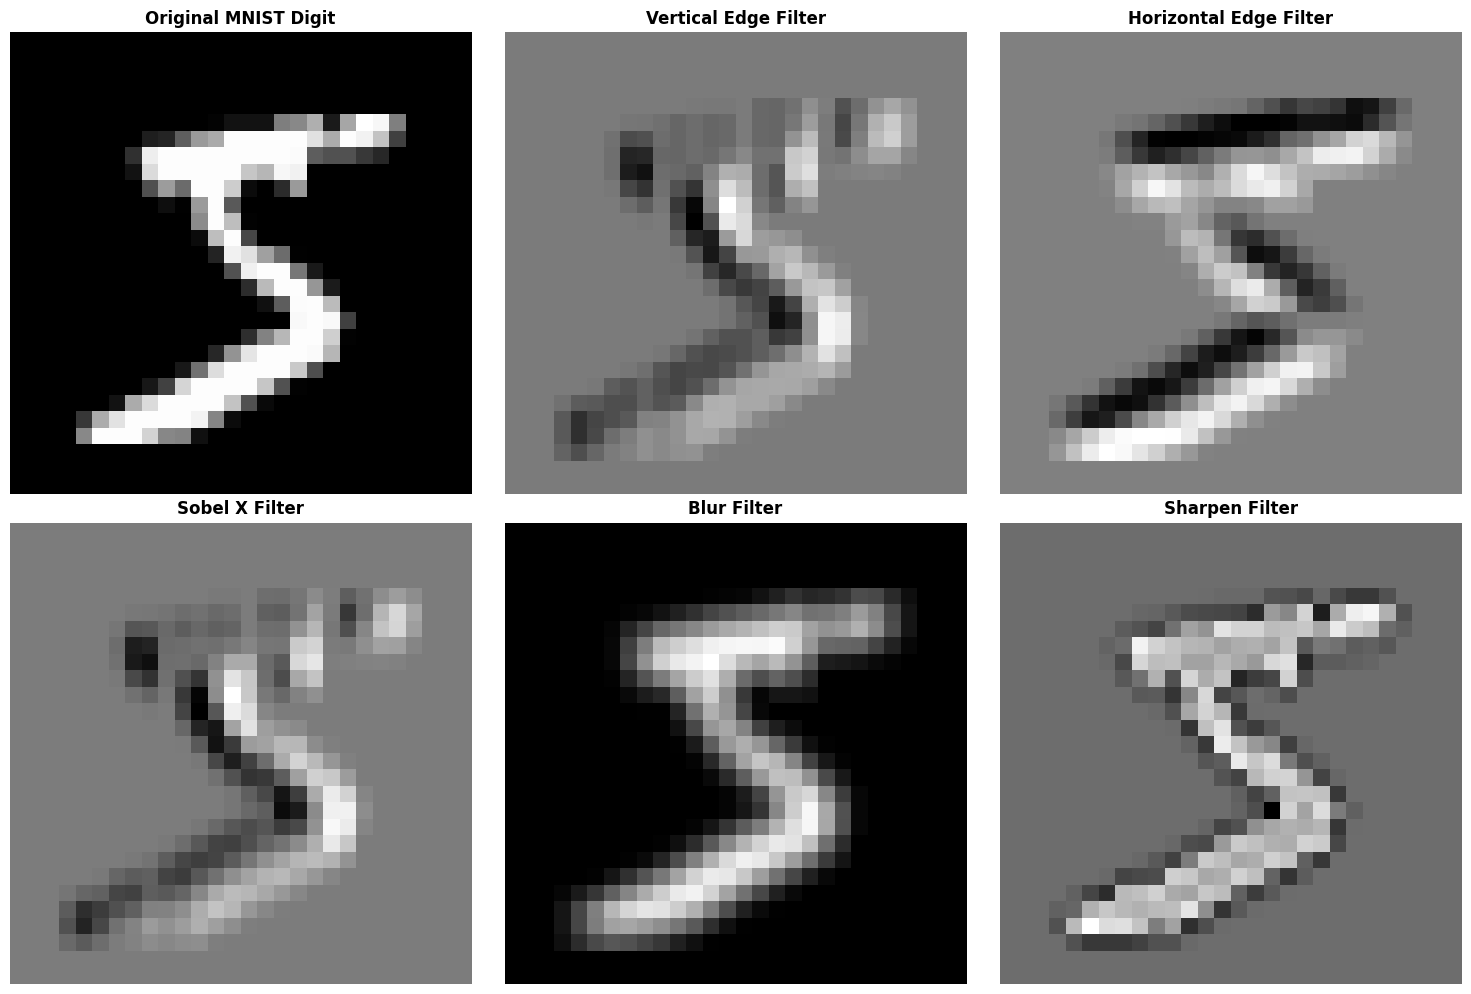

Each filter highlights different features!


In [3]:
# Let's try different filters on a real image

# Load an MNIST digit
mnist = datasets.MNIST('../data/datasets', train=True, download=True)
sample_image = mnist[0][0]  # First digit
img_array = np.array(sample_image, dtype=np.float32) / 255.0

# Define various filters
filters = {
    'Vertical Edge': np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]),
    'Horizontal Edge': np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]),
    'Sobel X': np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]),
    'Blur': np.ones((3, 3)) / 9,
    'Sharpen': np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
}

# Apply filters
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Original image
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title('Original MNIST Digit', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Apply each filter
for idx, (name, filt) in enumerate(filters.items(), start=1):
    feature_map = convolve2d(img_array, filt, mode='same')
    axes[idx].imshow(feature_map, cmap='gray')
    axes[idx].set_title(f'{name} Filter', fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

print("Each filter highlights different features!")

## Part 3: Convolution in PyTorch

### Conv2d Layer

PyTorch provides `nn.Conv2d` for 2D convolution:

```python
nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
```

**Parameters:**
- `in_channels`: Number of input channels (1 for grayscale, 3 for RGB)
- `out_channels`: Number of filters (feature maps to create)
- `kernel_size`: Size of the filter (e.g., 3 means 3×3)
- `stride`: Step size when sliding the filter (default=1)
- `padding`: Add zeros around the image (to preserve size)

### Key Concepts

#### **Stride**
- How many pixels to move the filter each step
- Stride=1: Move one pixel at a time (detailed)
- Stride=2: Skip pixels (faster, smaller output)

#### **Padding**
- Add zeros around the image border
- Prevents shrinking of feature maps
- Allows filters to process edge pixels properly

#### **Output Size Calculation**
```
Output_size = (Input_size - Kernel_size + 2*Padding) / Stride + 1
```

In [4]:
# Create a simple convolutional layer

# Define a Conv2d layer
# Input: 1 channel (grayscale), Output: 6 filters, Kernel: 3×3
conv_layer = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)

print("Convolutional Layer:")
print("="*50)
print(conv_layer)
print(f"\nNumber of parameters: {sum(p.numel() for p in conv_layer.parameters())}")
print(f"\nFilter weights shape: {conv_layer.weight.shape}")
print(f"Interpretation: (out_channels=6, in_channels=1, height=3, width=3)")

# Test with a sample image
sample_input = torch.randn(1, 1, 28, 28)  # (batch, channels, height, width)
output = conv_layer(sample_input)

print(f"\nInput shape: {sample_input.shape}")
print(f"Output shape: {output.shape}")
print(f"\nOutput interpretation: (batch=1, channels=6, height=28, width=28)")
print("\nWe went from 1 channel to 6 channels (6 different feature maps)!")

Convolutional Layer:
Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

Number of parameters: 60

Filter weights shape: torch.Size([6, 1, 3, 3])
Interpretation: (out_channels=6, in_channels=1, height=3, width=3)

Input shape: torch.Size([1, 1, 28, 28])
Output shape: torch.Size([1, 6, 28, 28])

Output interpretation: (batch=1, channels=6, height=28, width=28)

We went from 1 channel to 6 channels (6 different feature maps)!


## Part 4: Pooling Layers

### What is Pooling?

**Pooling** reduces the spatial dimensions of feature maps while keeping important information.

### Why Pooling?

1. **Reduce computational cost** - Fewer pixels to process
2. **Reduce overfitting** - Less parameters
3. **Increase receptive field** - Each neuron "sees" more of the image
4. **Add translation invariance** - Small shifts don't matter

### Types of Pooling

#### **Max Pooling**
- Takes the maximum value in each region
- Most common type
- Keeps the strongest activation (most important feature)

#### **Average Pooling**
- Takes the average value in each region
- Smoother, but less commonly used

### Example: 2×2 Max Pooling

```
Input (4×4):          Output (2×2):
[1, 3, 2, 4]          [3, 4]
[2, 1, 5, 3]    -->   [6, 8]
[4, 6, 1, 2]
[3, 2, 7, 8]
```

Divide into 2×2 regions, take max from each!

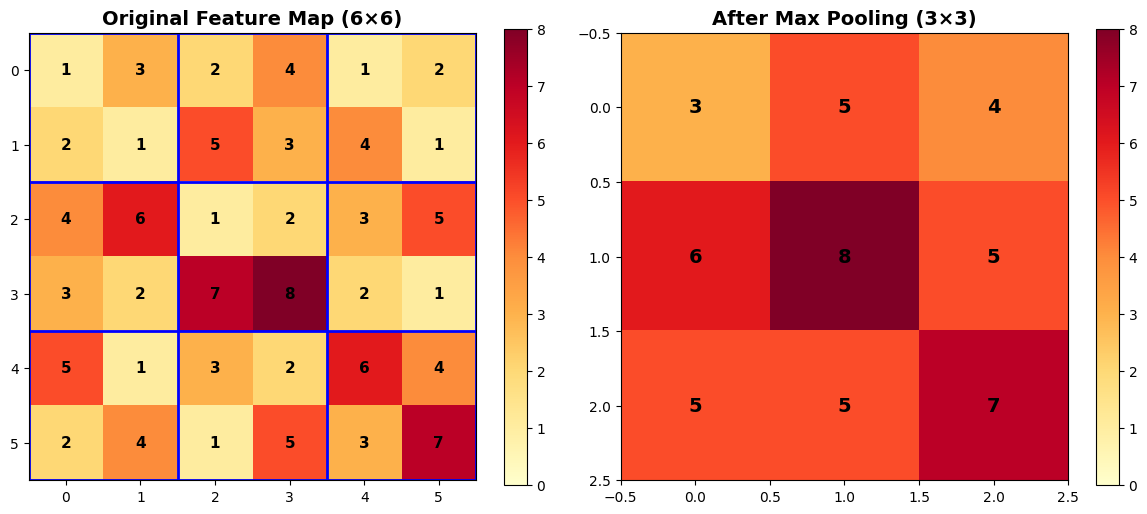

Original size: (6, 6)
After pooling: (3, 3)
Size reduction: 75.0%


In [5]:
# Visualize max pooling

# Create a sample feature map
feature_map = np.array([
    [1, 3, 2, 4, 1, 2],
    [2, 1, 5, 3, 4, 1],
    [4, 6, 1, 2, 3, 5],
    [3, 2, 7, 8, 2, 1],
    [5, 1, 3, 2, 6, 4],
    [2, 4, 1, 5, 3, 7]
], dtype=np.float32)

# Apply max pooling using PyTorch
feature_tensor = torch.from_numpy(feature_map).unsqueeze(0).unsqueeze(0)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
pooled = pool(feature_tensor)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original
im1 = axes[0].imshow(feature_map, cmap='YlOrRd', vmin=0, vmax=8)
axes[0].set_title('Original Feature Map (6×6)', fontsize=14, fontweight='bold')
for i in range(6):
    for j in range(6):
        axes[0].text(j, i, f'{feature_map[i,j]:.0f}',
                    ha='center', va='center', fontsize=11, fontweight='bold')
# Add grid to show pooling regions
for i in range(0, 7, 2):
    axes[0].axhline(i-0.5, color='blue', linewidth=2)
    axes[0].axvline(i-0.5, color='blue', linewidth=2)
plt.colorbar(im1, ax=axes[0])

# Pooled
pooled_array = pooled.squeeze().numpy()
im2 = axes[1].imshow(pooled_array, cmap='YlOrRd', vmin=0, vmax=8)
axes[1].set_title('After Max Pooling (3×3)', fontsize=14, fontweight='bold')
for i in range(3):
    for j in range(3):
        axes[1].text(j, i, f'{pooled_array[i,j]:.0f}',
                    ha='center', va='center', fontsize=14, fontweight='bold')
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

print(f"Original size: {feature_map.shape}")
print(f"After pooling: {pooled_array.shape}")
print(f"Size reduction: {(1 - pooled_array.size / feature_map.size) * 100:.1f}%")

## Part 5: Complete CNN Architecture

### Standard CNN Structure

A typical CNN consists of:

```
Input Image
    ↓
[Conv → ReLU → Pool] ← Repeat multiple times
    ↓
[Conv → ReLU → Pool]
    ↓
[Conv → ReLU → Pool]
    ↓
Flatten
    ↓
[Fully Connected → ReLU] ← Regular neural network layers
    ↓
[Fully Connected → Softmax]
    ↓
Output (Class Probabilities)
```

### What Each Part Does

#### **Early Layers** (Close to input)
- Detect simple features: edges, corners, colors
- Small receptive field
- Many feature maps (many different simple features)

#### **Middle Layers**
- Combine simple features into patterns
- Detect textures, parts of objects
- Medium receptive field

#### **Deep Layers** (Close to output)
- Detect complex patterns and whole objects
- Large receptive field
- "See" the entire image context

#### **Fully Connected Layers**
- Combine all features to make final decision
- Act like a regular neural network classifier

### Hierarchical Feature Learning

**This is the magic of CNNs!**

- **Layer 1**: Learns edges and simple patterns
- **Layer 2**: Combines edges into curves and corners
- **Layer 3**: Combines curves into parts (ears, eyes, wheels)
- **Layer 4**: Combines parts into objects (cats, cars)
- **Output**: Classifies the object

## Summary

Congratulations! You now understand how CNNs work!

### What You Learned:

1. **Why CNNs?**
   - Regular NNs lose spatial information
   - Too many parameters for images
   - Not translation invariant

2. **Convolution Operation**
   - Slide a filter across an image
   - Detect specific patterns
   - Create feature maps

3. **Filters**
   - Small matrices (e.g., 3×3)
   - Learn what patterns to detect
   - Different filters detect different features

4. **Pooling**
   - Reduces spatial dimensions
   - Keeps important information
   - Adds translation invariance

5. **CNN Architecture**
   - Stack Conv-ReLU-Pool blocks
   - Hierarchical feature learning
   - Flatten and classify with FC layers

### Key Takeaways:

- CNNs preserve spatial structure of images
- Convolution + pooling reduces parameters dramatically
- Early layers detect simple features, deep layers detect complex patterns
- The same filter is used across the entire image (parameter sharing)

### Next Steps:

Now you understand CNN theory! In Module 03, you'll:
- Build your first CNN from scratch
- Train it on MNIST digits
- Visualize what the network learns
- Achieve state-of-the-art performance!

**Ready to build your own CNN? Proceed to Module 03!**